In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def clean_education(s):
    lookup = {
        "Doctorate": "doctorate",
        "Masters": "masters",
        "Bachelors": "bachelors",
        "Assoc-voc": "associates",
        "Assoc-acdm": "associates",
        "Prof-school": "associates",
        "HS-grad": "highschool",
        "Some-college": "college_dropout",
    }
    return lookup.get(s, "incomplete_highschool")

In [3]:
clean_education('Dctorate')

'incomplete_highschool'

In [4]:
def clean_marital_status(s):
    married = {"Married-civ-spouse", "Married-AF-spouse"}
    previously_married = {"Divorced", "Separated", "Widowed", "Married-spouse-absent"}
    never_married = {"Never-married"}

    if s in married:
        return "married"
    if s in previously_married:
        return "previously_married"
    if s in never_married:
        return "never_married"

    raise Exception(f"Status {s} is not accounted for!")

In [5]:
def region_combining(x):
    north_america = ["Canada","Cuba","Dominican-Republic","El-Salvador","Guatemala","Haiti","Honduras","Jamaica","Mexico",
                     "Nicaragua","Outlying-US(Guam-USVI-etc)","Puerto-Rico","Trinadad&Tobago","United-States"]
    asia = ["Cambodia","China","Hong","India","Iran","Japan","Laos","Philippines","Taiwan","Thailand","Vietnam"]
    south_america = ["Columbia", "Ecuador", "Peru"]
    europe = ["England","France","Germany","Greece","Holand-Netherlands","Hungary","Ireland","Italy","Poland","Portugal",
              "Scotland","Yugoslavia"]
    other = ["South", "Unknown", "?"]

    if x in north_america:
        return "north_america"
    elif x in asia:
        return "asia"
    elif x in south_america:
        return "south_america"
    elif x in europe:
        return "europe"
    elif x in other:
        return "other"
    else:
        return x

    raise Exception(f"Country {x} is not accounted for!")

In [6]:
df = (
        pd.read_csv('census_data.csv')
        .rename(
            # replace " ", "-", and "." with "" in column names
            columns=lambda col: col.replace(" ", "_").replace("-", "_").replace(".", "")
        )
        .assign(
            # strip white spaces and replace "-" by "_"
            workclass=lambda df: df["workclass"].str.strip().replace('-', '_', regex=True),
            # strip white spaces and remap education column as defined in the clean_education function
            education=lambda df: df["education"].str.strip().map(clean_education), # or .apply(clean_education)
            # strip white spaces and remap marital_status column as defined in the clean_marital_status function
            marital_status=lambda df: df["marital_status"].str.strip().map(clean_marital_status),
            # strip white spaces and replace "-" by "_"
            occupation=lambda df: df["occupation"].str.strip().replace('-', '_', regex=True),
            # strip white spaces
            race=lambda df: df["race"].str.strip(),
            # strip white spaces
            sex=lambda df: df["sex"].str.strip(),
            # strip white spaces and remap native_country column as defined in the region_combining function,
            # save the result in a new column native_continent
            native_continent=lambda df: df["native_country"].str.strip().apply(region_combining),
            # create a new column from_us to indicate where from the USA
            from_us=lambda df: df["native_country"].str.strip() == "United-States",
            # create a new column salary_gt_50k to indicate salary >50k
            salary_gt_50k=lambda df: df["salary"].str.strip() == ">50K",
        )
        .loc[
            # exclusion criteria
            lambda df: (~df["workclass"].isin(["Without_pay", "Never_worked"]))
                        & (df["occupation"] != "Armed_Forces")
        ]
        .drop(["native_country", "salary", "fnlwgt"], axis=1) # drop unwanted columns
        .assign(
            # impute missing values in age with mean age
            age=lambda df: df["age"].fillna(df["age"].mean()),
            # replace '?' wih 'Unknown' in workclass and occupation columns
            workclass=lambda df: df["workclass"].str.replace(r'\?','Unknown', regex=True),
            occupation=lambda df: df["occupation"].str.replace(r'\?','Unknown', regex=True)
        )
    )

In [7]:
df.isnull().sum()

age                       0
workclass                 0
education                 0
education_no_of_years     0
marital_status            0
occupation                0
race                      0
sex                       0
capital_gain              0
capital_loss              0
working_hours_per_week    0
native_continent          0
from_us                   0
salary_gt_50k             0
dtype: int64

In [8]:
df.head()

,age,workclass,education,education_no_of_years,marital_status,occupation,race,sex,capital_gain,capital_loss,working_hours_per_week,native_continent,from_us,salary_gt_50k
0,39.0,State_gov,bachelors,13,never_married,Adm_clerical,White,Male,2174,0,40,north_america,True,False
1,50.0,Self_emp_not_inc,bachelors,13,married,Exec_managerial,White,Male,0,0,13,north_america,True,False
2,38.0,Private,highschool,9,previously_married,Handlers_cleaners,White,Male,0,0,40,north_america,True,False
3,53.0,Private,incomplete_highschool,7,married,Handlers_cleaners,Black,Male,0,0,40,north_america,True,False
4,28.0,Private,bachelors,13,married,Prof_specialty,Black,Female,0,0,40,north_america,False,False


## Exploratory Data Analysis (EDA)

### Univariate Analysis

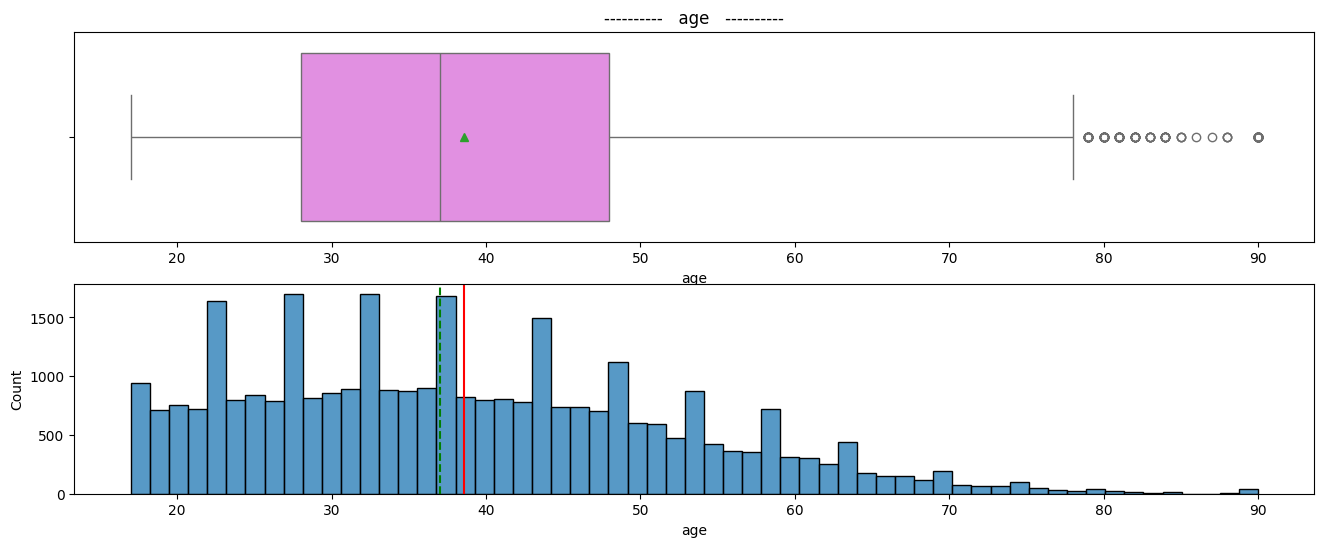

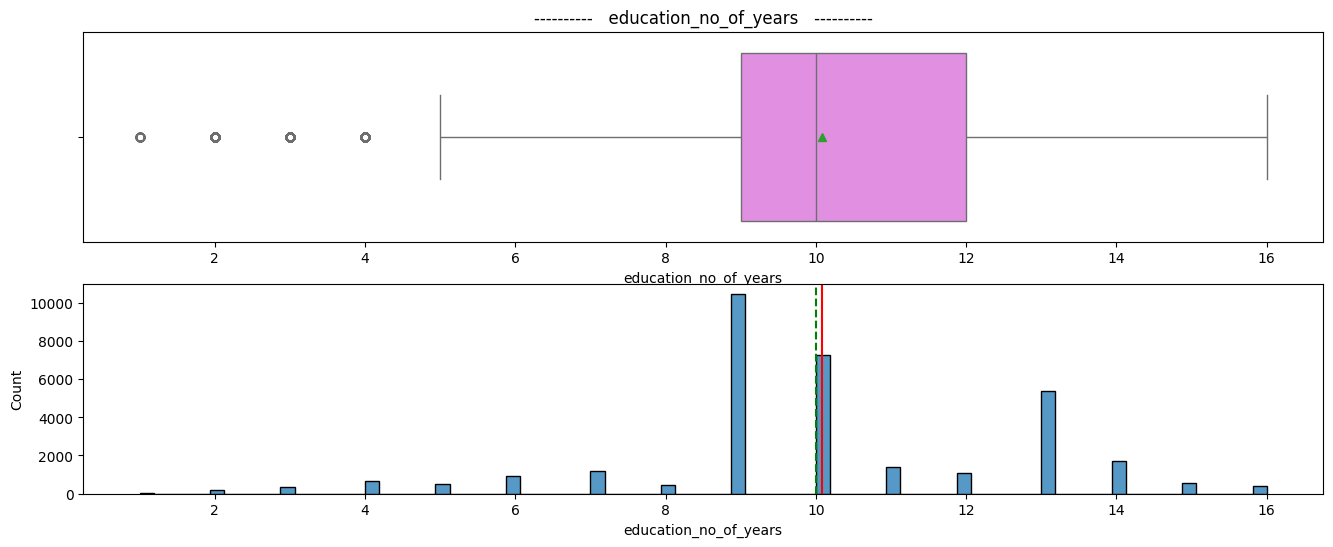

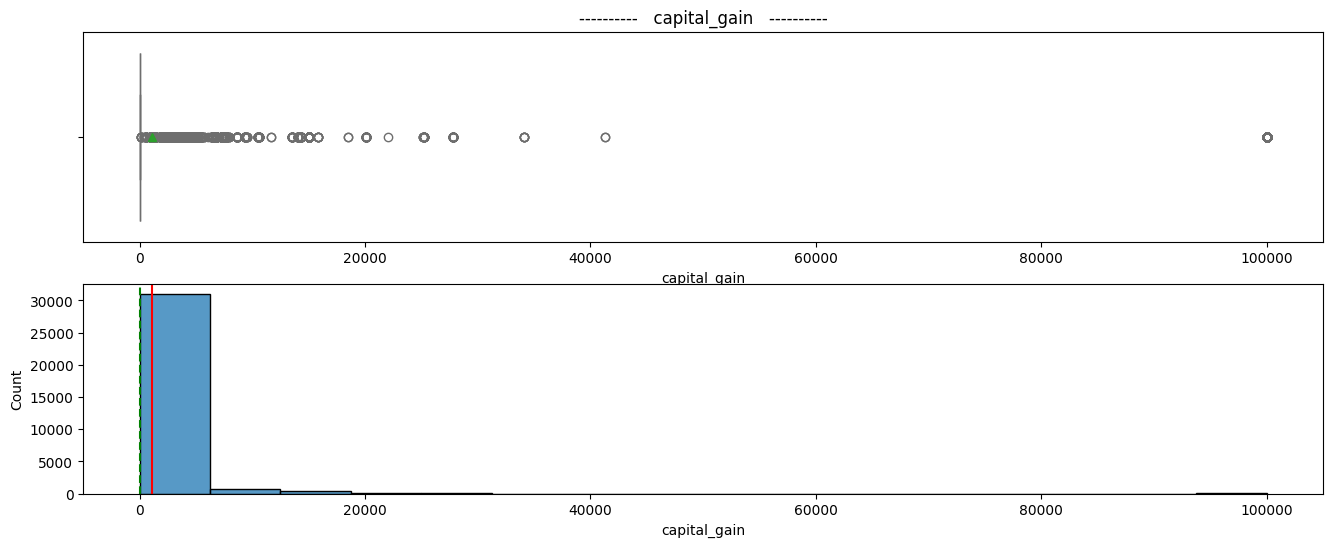

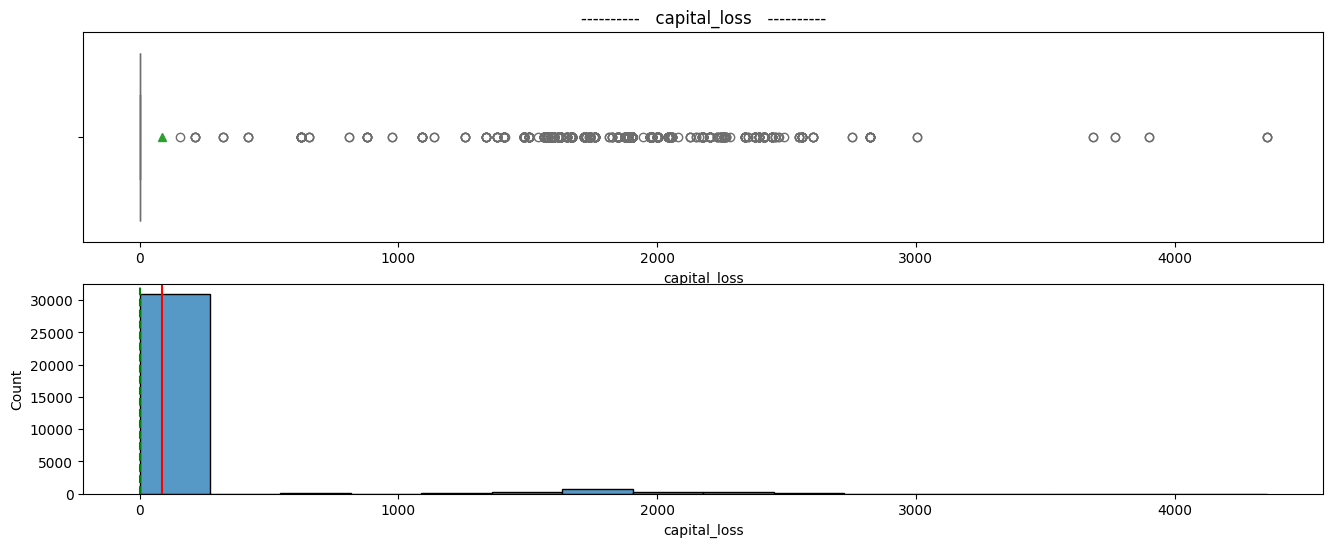

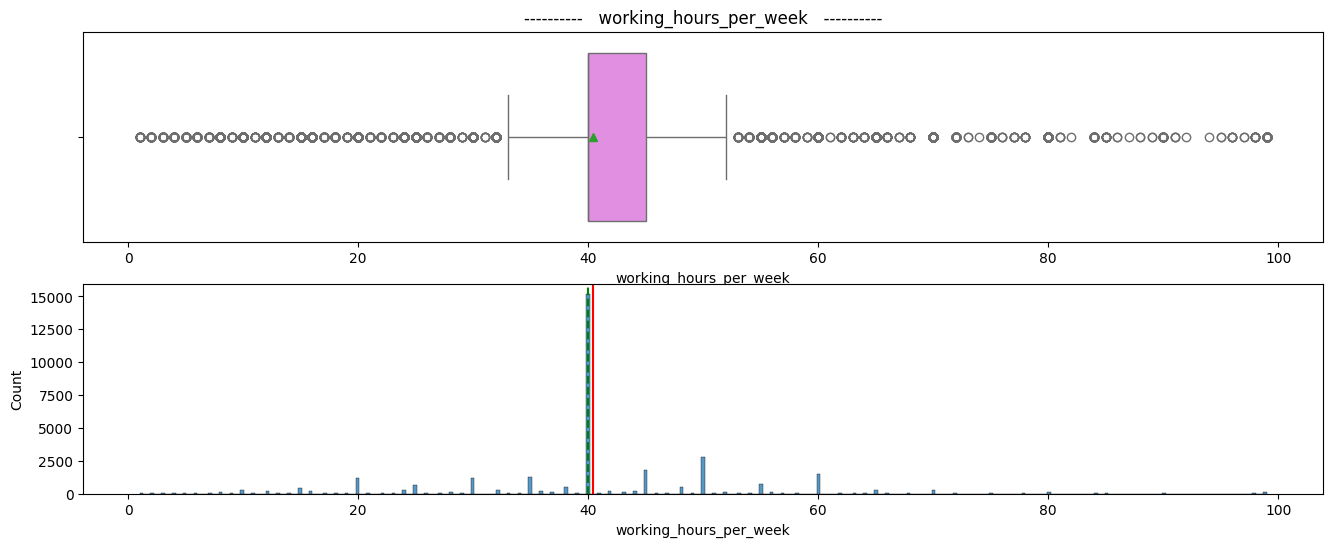

In [9]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for col in num_col:
    plt.figure(figsize=(16, 6))
    plt.subplot(2, 1, 1)
    plt.title("----------   " + col + "   ----------")
    sns.boxplot(data=df, x=col, showmeans=True, color="violet")
    plt.subplot(2, 1, 2)
    sns.histplot(data=df, x=col)
    plt.axvline(df[col].mean(), color="red", linestyle="-")
    plt.axvline(df[col].median(), color="green", linestyle="--")
    plt.show()

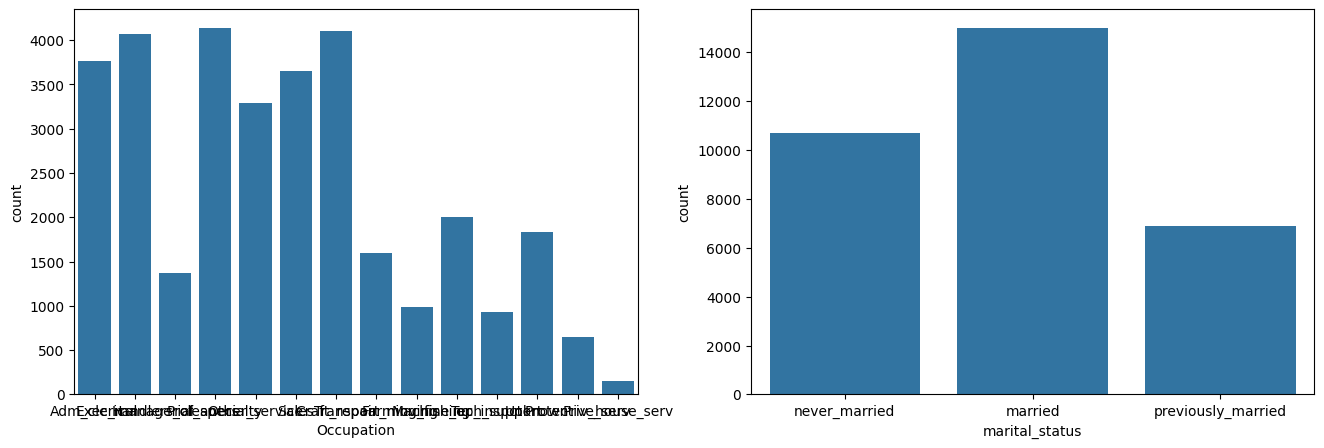

In [10]:

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

# plot 1
sns.countplot(data=df, x='occupation', ax=ax1)
ax1.set(xlabel='Occupation')
# plot 2
sns.countplot(data=df, x='marital_status', ax=ax2)
ax2.set(xlabel='marital_status');


### Multivariate analysis

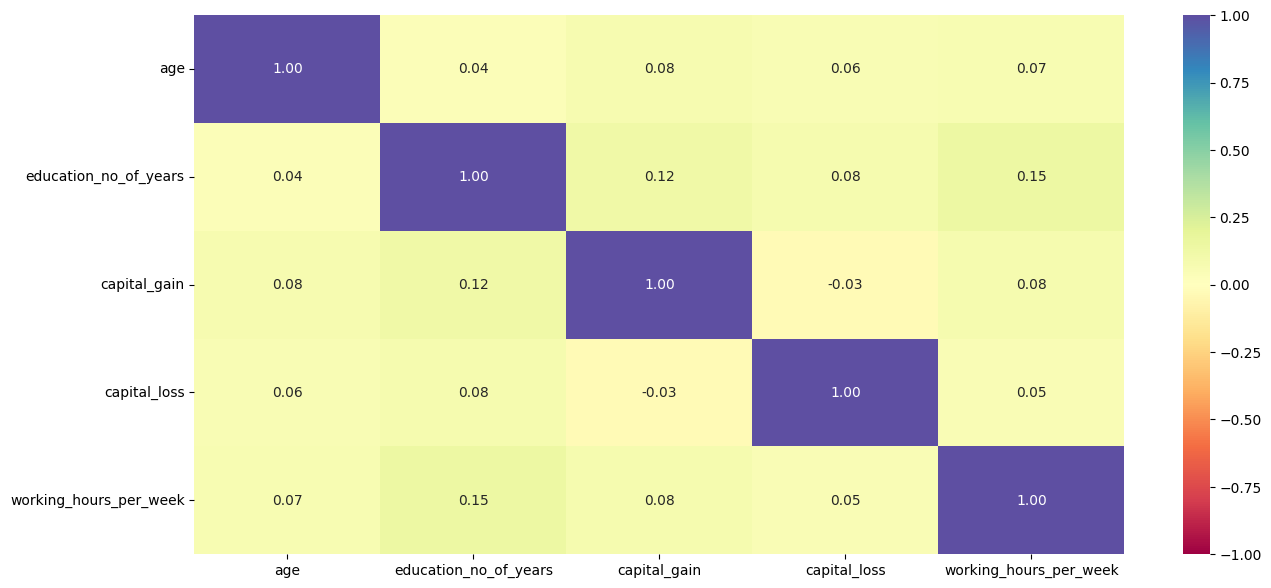

In [11]:
# heapmap
num_col = df.select_dtypes(np.number).columns
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

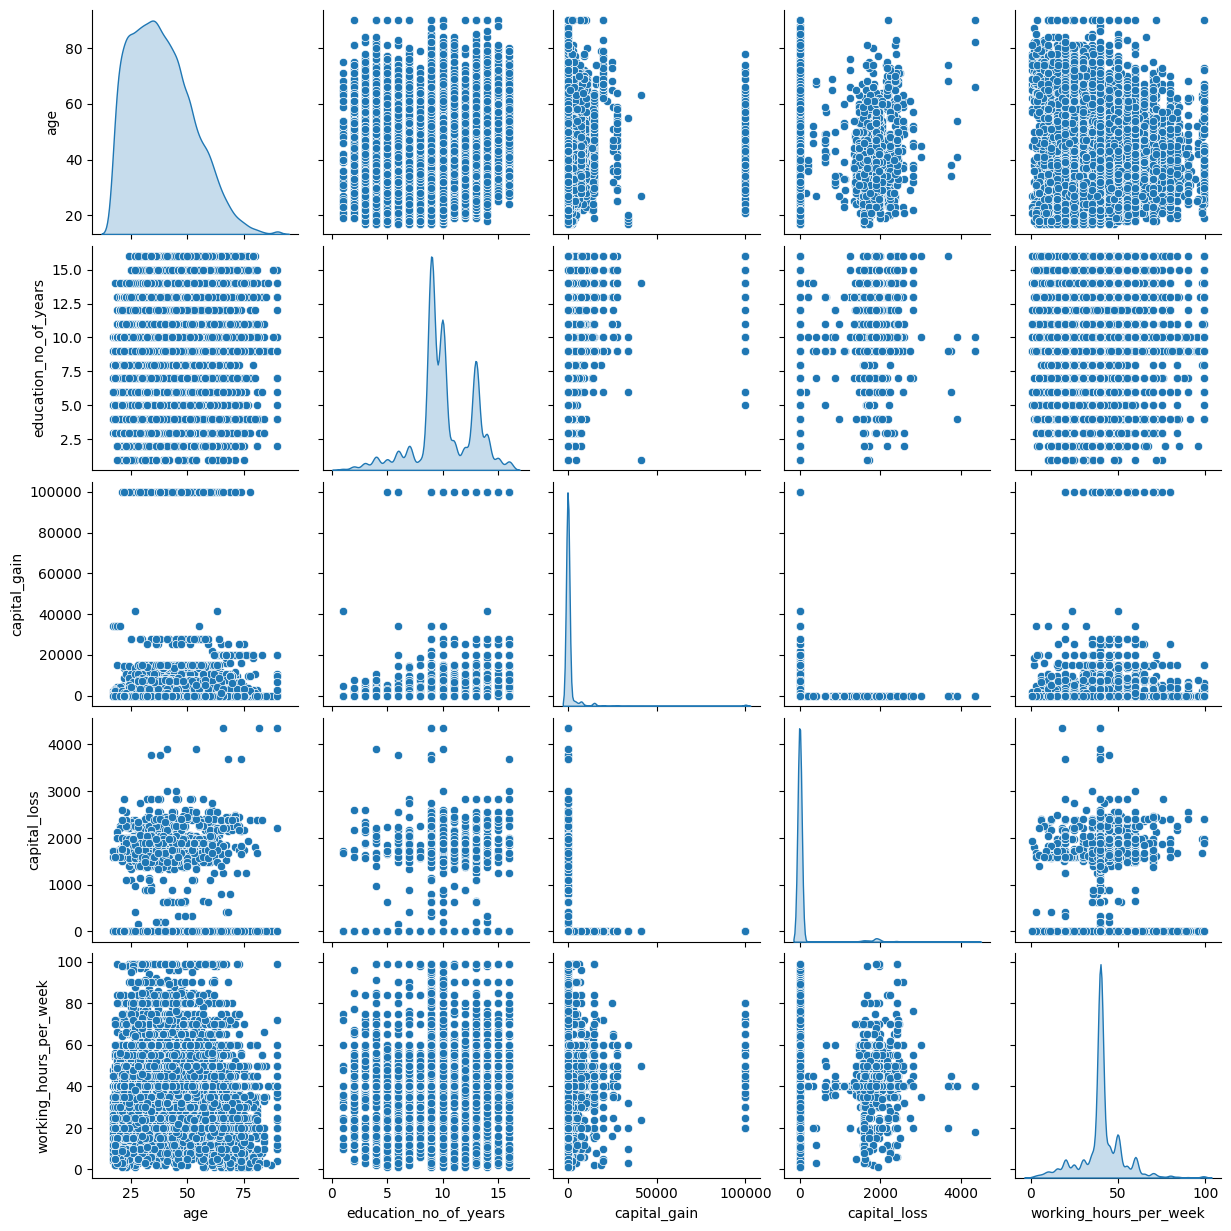

In [12]:
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

In [13]:
df.head()

,age,workclass,education,education_no_of_years,marital_status,occupation,race,sex,capital_gain,capital_loss,working_hours_per_week,native_continent,from_us,salary_gt_50k
0,39.0,State_gov,bachelors,13,never_married,Adm_clerical,White,Male,2174,0,40,north_america,True,False
1,50.0,Self_emp_not_inc,bachelors,13,married,Exec_managerial,White,Male,0,0,13,north_america,True,False
2,38.0,Private,highschool,9,previously_married,Handlers_cleaners,White,Male,0,0,40,north_america,True,False
3,53.0,Private,incomplete_highschool,7,married,Handlers_cleaners,Black,Male,0,0,40,north_america,True,False
4,28.0,Private,bachelors,13,married,Prof_specialty,Black,Female,0,0,40,north_america,False,False


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32531 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     32531 non-null  float64
 1   workclass               32531 non-null  object 
 2   education               32531 non-null  object 
 3   education_no_of_years   32531 non-null  int64  
 4   marital_status          32531 non-null  object 
 5   occupation              32531 non-null  object 
 6   race                    32531 non-null  object 
 7   sex                     32531 non-null  object 
 8   capital_gain            32531 non-null  int64  
 9   capital_loss            32531 non-null  int64  
 10  working_hours_per_week  32531 non-null  int64  
 11  native_continent        32531 non-null  object 
 12  from_us                 32531 non-null  bool   
 13  salary_gt_50k           32531 non-null  bool   
dtypes: bool(2), float64(1), int64(4), object(7)

In [15]:
categorical_columns = df.select_dtypes('object').columns.tolist()

In [16]:
df[categorical_columns].head()

,workclass,education,marital_status,occupation,race,sex,native_continent
0,State_gov,bachelors,never_married,Adm_clerical,White,Male,north_america
1,Self_emp_not_inc,bachelors,married,Exec_managerial,White,Male,north_america
2,Private,highschool,previously_married,Handlers_cleaners,White,Male,north_america
3,Private,incomplete_highschool,married,Handlers_cleaners,Black,Male,north_america
4,Private,bachelors,married,Prof_specialty,Black,Female,north_america


In [17]:
pd.get_dummies(df[categorical_columns], drop_first=True).head()

,workclass_Local_gov,workclass_Private,workclass_Self_emp_inc,workclass_Self_emp_not_inc,workclass_State_gov,workclass_Unknown,education_bachelors,education_college_dropout,education_doctorate,education_highschool,...,occupation_Unknown,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native_continent_europe,native_continent_north_america,native_continent_other,native_continent_south_america
0,False,False,False,False,True,False,True,False,False,False,...,False,False,False,False,True,True,False,True,False,False
1,False,False,False,True,False,False,True,False,False,False,...,False,False,False,False,True,True,False,True,False,False
2,False,True,False,False,False,False,False,False,False,True,...,False,False,False,False,True,True,False,True,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,True,False,False
4,False,True,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,False


In [18]:
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
df.head()

,age,education_no_of_years,capital_gain,capital_loss,working_hours_per_week,from_us,salary_gt_50k,workclass_Local_gov,workclass_Private,workclass_Self_emp_inc,...,occupation_Unknown,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native_continent_europe,native_continent_north_america,native_continent_other,native_continent_south_america
0,39.0,13,2174,0,40,True,False,False,False,False,...,False,False,False,False,True,True,False,True,False,False
1,50.0,13,0,0,13,True,False,False,False,False,...,False,False,False,False,True,True,False,True,False,False
2,38.0,9,0,0,40,True,False,False,True,False,...,False,False,False,False,True,True,False,True,False,False
3,53.0,7,0,0,40,True,False,False,True,False,...,False,False,True,False,False,True,False,True,False,False
4,28.0,13,0,0,40,False,False,False,True,False,...,False,False,True,False,False,False,False,True,False,False


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [20]:
logres = LogisticRegression()
features = df.drop('salary_gt_50k', axis=1)
target = df['salary_gt_50k']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, stratify=target)

In [21]:
X_test.head()

,age,education_no_of_years,capital_gain,capital_loss,working_hours_per_week,from_us,workclass_Local_gov,workclass_Private,workclass_Self_emp_inc,workclass_Self_emp_not_inc,...,occupation_Unknown,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native_continent_europe,native_continent_north_america,native_continent_other,native_continent_south_america
26725,56.0,10,0,1977,50,True,False,False,False,True,...,False,False,False,False,True,False,False,True,False,False
24222,58.0,9,0,0,40,True,False,True,False,False,...,False,False,False,False,True,False,False,True,False,False
29853,51.0,3,0,0,40,False,False,True,False,False,...,False,False,False,False,True,False,False,True,False,False
6793,23.0,13,0,0,5,True,False,True,False,False,...,False,False,False,False,True,False,False,True,False,False
13614,22.0,13,0,0,40,True,False,True,False,False,...,False,False,False,False,True,False,False,True,False,False


In [22]:
logres_trained = logres.fit(X_train, y_train)

In [23]:
logres_trained

LogisticRegression()

In [24]:
logres_trained.predict(X_test)

array([ True, False, False, ..., False,  True, False])